# Установка зависимостей

In [ ]:
!pip install momentumnet
!pip install memory-profiler

# Тестируем потребление по памяти

Из за особенностей выделения памяти в питоне для честности экспериментов перед каждой попыткой нужно перезапускать кернел

In [ ]:
import torchvision
import torch
import momentumnet
import random
from momentumnet import MomentumNet
from tqdm import tqdm
import numpy as np
from memory_profiler import memory_usage
import torch.nn as nn
from matplotlib import pyplot as plt

In [ ]:
torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

Фиксируем параметры текущего эксперимента

In [ ]:
batch_size = 80

input = torch.rand(batch_size, 3, 224, 224)
target = torch.zeros(batch_size).long()
criterion = torch.nn.CrossEntropyLoss()

def dummy_loss(model):
    loss = criterion(model(input), target)
    return loss.backward()

model = torchvision.models.resnet152

Запускаем для обычной или моментум сети, не забываем рестартовать кернел перед следующим запуском, иначе можно получить искаженные результаты

In [ ]:
mr = momentumnet.transform_to_momentumnet(model(), gamma=0.9)
np.max(memory_usage((dummy_loss, [mr], )))

In [ ]:
r = model()
np.max(memory_usage((dummy_loss, [r], )))

### Потребление разными моделями

In [ ]:
models = ['18', '34', '50', '101', '152']

resnet = [2806.234375, 3236.23, 6542.73, 9185.57, 12015.875]
mresnet09 = [3258.21, 3384.91, 7968.92, 8156.78, 8544.05]
mresnet05 = [3106.77, 3499.62, 8063.99, 8727.87, 8549.5625]
mresnet01 = [3107.1, 3388.26, 8401.55, 8160.5, 8327.9]

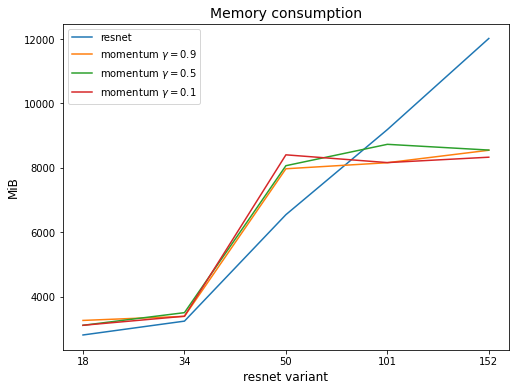

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(models, resnet, label='resnet')
plt.plot(models, mresnet09, label=r'momentum $\gamma=0.9$')
plt.plot(models, mresnet05, label=r'momentum $\gamma=0.5$')
plt.plot(models, mresnet01, label=r'momentum $\gamma=0.1$')
plt.title('Memory consumption', fontsize=14)
plt.xlabel('resnet variant', fontsize=12)
plt.ylabel('MiB', fontsize=12)
plt.legend()
plt.savefig('1', dpi=150)
plt.show()

### Resnet152 разные размера батча

In [ ]:
batch_sizes = [16, 32, 48, 64, 80]
resnet152 = [4115.05, 6850.29, 9538.07, 11990.77]
mresnet152_09 = [3297.14, 4891.75, 6695.15, 8558.61, 10517.61]

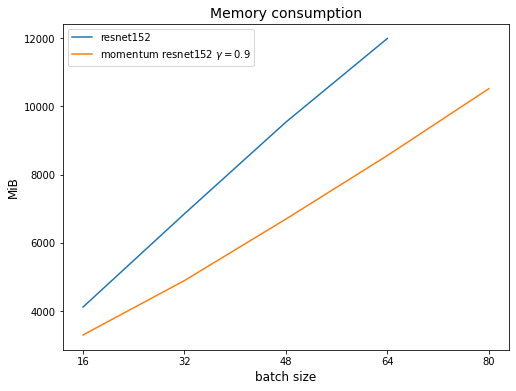

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes[:-1], resnet152, label='resnet152')
plt.plot(batch_sizes, mresnet152_09, label=r'momentum resnet152 $\gamma=0.9$')
plt.title('Memory consumption', fontsize=14)
plt.xlabel('batch size', fontsize=12)
plt.ylabel('MiB', fontsize=12)
plt.xticks(batch_sizes)
plt.legend()
plt.savefig('2', dpi=150)
plt.show()


# Fine-tuning momentum модели. Сравнение с обычной моделью

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [ ]:
cifar_train = torchvision.datasets.CIFAR10('cifar_train', train=True, download=True, transform=train_transforms)
cifar_test = torchvision.datasets.CIFAR10('cifar_test', train=False, download=True, transform=val_transforms)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=128)
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)

CRITERION = torch.nn.CrossEntropyLoss().to(device)
N_CLASSES = 10

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
@torch.no_grad()
def test(model):
    model.eval()

    preds = []
    targets = []
    cur_loss = 0
    cur_iter = 0


    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)

        loss = CRITERION(logits, y)

        cur_loss += loss.item()
        cur_iter += 1
                
        preds.append(torch.max(logits, dim=1)[1].cpu())
        targets.append(y.cpu())
        
    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()

    return cur_loss / cur_iter, (preds == targets).mean()


def train(model, optimizer, num_epoch):
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    for epoch in range(1, num_epoch):
        progress_bar = tqdm(train_loader, leave=True, position=0)
        cur_loss = 0
        cur_iter = 0

        preds = []
        targets = []
        
        model.train()
        for idx, (x, y) in enumerate(progress_bar):
            
            optimizer.zero_grad()
            
            x = x.cuda()
            y = y.cuda()
            
            logits = model(x)
            loss = CRITERION(logits, y)

            with torch.no_grad():
                preds.append(torch.max(logits, dim=1)[1].cpu())
                targets.append(y.cpu())
            
            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            cur_iter += 1
            
            progress_bar.set_postfix({
                'Epoch': epoch,
                'Loss': cur_loss / cur_iter
            })

        preds = torch.cat(preds).numpy()
        targets = torch.cat(targets).numpy()   
        
        val_loss, val_acc = test(model)
        test_losses.append(val_loss)
        test_acc.append(val_acc)

        train_losses.append(cur_loss / cur_iter)
        train_acc.append((preds == targets).mean())
     
        print(f'Epoch {epoch} ended, Train Loss: {cur_loss / cur_iter}, Val Loss: {val_loss}')
        print(f'Train Accuracy: {(preds == targets).mean()} Val Accuracy: {val_acc}')
    
    return train_losses, test_losses, train_acc, test_acc

In [ ]:
model = torchvision.models.resnet18(pretrained=True).to(device)
model.fc = torch.nn.Linear(model.fc.in_features, N_CLASSES).to(device)

train_losses, test_losses, train_acc, test_acc = train(model, torch.optim.SGD(params=model.parameters(), lr=0.01, weight_decay=5e-4), 40)

100%|██████████| 391/391 [00:48<00:00,  8.03it/s, Epoch=1, Loss=1.27]


Epoch 1 ended, Train Loss: 1.2653741859414083, Val Loss: 0.9590778735619557
Train Accuracy: 0.55524 Val Accuracy: 0.6656


100%|██████████| 391/391 [00:46<00:00,  8.41it/s, Epoch=2, Loss=0.889]


Epoch 2 ended, Train Loss: 0.8889034276118364, Val Loss: 0.7829668484156644
Train Accuracy: 0.6891 Val Accuracy: 0.7294


100%|██████████| 391/391 [00:46<00:00,  8.36it/s, Epoch=3, Loss=0.768]


Epoch 3 ended, Train Loss: 0.7683108278247707, Val Loss: 0.6945820854434485
Train Accuracy: 0.7321 Val Accuracy: 0.7596


100%|██████████| 391/391 [00:46<00:00,  8.34it/s, Epoch=4, Loss=0.692]


Epoch 4 ended, Train Loss: 0.6915402841537505, Val Loss: 0.6521183440956888
Train Accuracy: 0.75772 Val Accuracy: 0.7776


100%|██████████| 391/391 [00:47<00:00,  8.28it/s, Epoch=5, Loss=0.636]


Epoch 5 ended, Train Loss: 0.6360286112941439, Val Loss: 0.6289257871199257
Train Accuracy: 0.77694 Val Accuracy: 0.7825


100%|██████████| 391/391 [00:47<00:00,  8.28it/s, Epoch=6, Loss=0.597]


Epoch 6 ended, Train Loss: 0.5965618638278883, Val Loss: 0.6091172178334827
Train Accuracy: 0.79144 Val Accuracy: 0.7915


100%|██████████| 391/391 [00:47<00:00,  8.15it/s, Epoch=7, Loss=0.561]


Epoch 7 ended, Train Loss: 0.5608728334422002, Val Loss: 0.5931341493431526
Train Accuracy: 0.80426 Val Accuracy: 0.7978


100%|██████████| 391/391 [00:46<00:00,  8.33it/s, Epoch=8, Loss=0.528]


Epoch 8 ended, Train Loss: 0.5275172175806196, Val Loss: 0.5711371808112422
Train Accuracy: 0.8159 Val Accuracy: 0.8071


100%|██████████| 391/391 [00:46<00:00,  8.32it/s, Epoch=9, Loss=0.505]


Epoch 9 ended, Train Loss: 0.5047699583460913, Val Loss: 0.5540355462816697
Train Accuracy: 0.8249 Val Accuracy: 0.8093


100%|██████████| 391/391 [00:46<00:00,  8.41it/s, Epoch=10, Loss=0.489]


Epoch 10 ended, Train Loss: 0.4892454120661596, Val Loss: 0.5400721570359001
Train Accuracy: 0.82954 Val Accuracy: 0.8178


100%|██████████| 391/391 [00:46<00:00,  8.39it/s, Epoch=11, Loss=0.465]


Epoch 11 ended, Train Loss: 0.4645681528331679, Val Loss: 0.5369113823281059
Train Accuracy: 0.83656 Val Accuracy: 0.8193


100%|██████████| 391/391 [00:46<00:00,  8.37it/s, Epoch=12, Loss=0.442]


Epoch 12 ended, Train Loss: 0.4418825070037866, Val Loss: 0.5407891775233836
Train Accuracy: 0.8465 Val Accuracy: 0.8189


100%|██████████| 391/391 [00:47<00:00,  8.30it/s, Epoch=13, Loss=0.429]


Epoch 13 ended, Train Loss: 0.429312429998232, Val Loss: 0.5425472704670097
Train Accuracy: 0.84888 Val Accuracy: 0.8249


100%|██████████| 391/391 [00:48<00:00,  8.14it/s, Epoch=14, Loss=0.409]


Epoch 14 ended, Train Loss: 0.40933542170792897, Val Loss: 0.5205541626562046
Train Accuracy: 0.85546 Val Accuracy: 0.8271


100%|██████████| 391/391 [00:47<00:00,  8.23it/s, Epoch=15, Loss=0.395]


Epoch 15 ended, Train Loss: 0.39512754961505264, Val Loss: 0.5232699321040625
Train Accuracy: 0.86084 Val Accuracy: 0.8269


100%|██████████| 391/391 [00:47<00:00,  8.26it/s, Epoch=16, Loss=0.377]


Epoch 16 ended, Train Loss: 0.3768814888299274, Val Loss: 0.5251393487936333
Train Accuracy: 0.86706 Val Accuracy: 0.8326


100%|██████████| 391/391 [00:46<00:00,  8.33it/s, Epoch=17, Loss=0.363]


Epoch 17 ended, Train Loss: 0.36298431357002015, Val Loss: 0.528357694797878
Train Accuracy: 0.87124 Val Accuracy: 0.8267


100%|██████████| 391/391 [00:47<00:00,  8.20it/s, Epoch=18, Loss=0.343]


Epoch 18 ended, Train Loss: 0.3431770350317211, Val Loss: 0.5149386838267122
Train Accuracy: 0.8772 Val Accuracy: 0.8342


100%|██████████| 391/391 [00:47<00:00,  8.25it/s, Epoch=19, Loss=0.334]


Epoch 19 ended, Train Loss: 0.3336986842972543, Val Loss: 0.5377811053885689
Train Accuracy: 0.88048 Val Accuracy: 0.8278


100%|██████████| 391/391 [00:46<00:00,  8.41it/s, Epoch=20, Loss=0.326]


Epoch 20 ended, Train Loss: 0.3259126550477484, Val Loss: 0.5205608915679062
Train Accuracy: 0.88416 Val Accuracy: 0.8326


100%|██████████| 391/391 [00:47<00:00,  8.32it/s, Epoch=21, Loss=0.311]


Epoch 21 ended, Train Loss: 0.3113030418181968, Val Loss: 0.5281361503691613
Train Accuracy: 0.8884 Val Accuracy: 0.8315


100%|██████████| 391/391 [00:47<00:00,  8.23it/s, Epoch=22, Loss=0.298]


Epoch 22 ended, Train Loss: 0.297719097312759, Val Loss: 0.5302758805359467
Train Accuracy: 0.8929 Val Accuracy: 0.8325


100%|██████████| 391/391 [00:48<00:00,  8.09it/s, Epoch=23, Loss=0.289]


Epoch 23 ended, Train Loss: 0.28916475504560546, Val Loss: 0.53535020275961
Train Accuracy: 0.8969 Val Accuracy: 0.8326


100%|██████████| 391/391 [00:47<00:00,  8.28it/s, Epoch=24, Loss=0.281]


Epoch 24 ended, Train Loss: 0.2812932953429039, Val Loss: 0.5282951785793787
Train Accuracy: 0.90164 Val Accuracy: 0.8357


100%|██████████| 391/391 [00:46<00:00,  8.32it/s, Epoch=25, Loss=0.269]


Epoch 25 ended, Train Loss: 0.2686142874953082, Val Loss: 0.5476094261754917
Train Accuracy: 0.90324 Val Accuracy: 0.834


100%|██████████| 391/391 [00:47<00:00,  8.31it/s, Epoch=26, Loss=0.259]


Epoch 26 ended, Train Loss: 0.25914831232765445, Val Loss: 0.5336856974076621
Train Accuracy: 0.90766 Val Accuracy: 0.8363


100%|██████████| 391/391 [00:47<00:00,  8.26it/s, Epoch=27, Loss=0.251]


Epoch 27 ended, Train Loss: 0.2514905235575288, Val Loss: 0.5471824290631693
Train Accuracy: 0.90952 Val Accuracy: 0.8356


100%|██████████| 391/391 [00:47<00:00,  8.24it/s, Epoch=28, Loss=0.243]


Epoch 28 ended, Train Loss: 0.24296615145090597, Val Loss: 0.5562845676005641
Train Accuracy: 0.91352 Val Accuracy: 0.8348


100%|██████████| 391/391 [00:46<00:00,  8.32it/s, Epoch=29, Loss=0.23]


Epoch 29 ended, Train Loss: 0.22978804752116314, Val Loss: 0.5557588859449459
Train Accuracy: 0.9175 Val Accuracy: 0.8363


100%|██████████| 391/391 [00:47<00:00,  8.30it/s, Epoch=30, Loss=0.224]


Epoch 30 ended, Train Loss: 0.22417322504322243, Val Loss: 0.5614510748205306
Train Accuracy: 0.91936 Val Accuracy: 0.8337


100%|██████████| 391/391 [00:47<00:00,  8.25it/s, Epoch=31, Loss=0.215]


Epoch 31 ended, Train Loss: 0.21494893906900034, Val Loss: 0.555192275137841
Train Accuracy: 0.92292 Val Accuracy: 0.839


100%|██████████| 391/391 [00:46<00:00,  8.36it/s, Epoch=32, Loss=0.21]


Epoch 32 ended, Train Loss: 0.20997261320767197, Val Loss: 0.5496976632106153
Train Accuracy: 0.9261 Val Accuracy: 0.8387


100%|██████████| 391/391 [00:47<00:00,  8.32it/s, Epoch=33, Loss=0.201]


Epoch 33 ended, Train Loss: 0.20106983070483292, Val Loss: 0.560557413327543
Train Accuracy: 0.92804 Val Accuracy: 0.8411


100%|██████████| 391/391 [00:47<00:00,  8.22it/s, Epoch=34, Loss=0.196]


Epoch 34 ended, Train Loss: 0.1958795441576587, Val Loss: 0.548237564443033
Train Accuracy: 0.9292 Val Accuracy: 0.8418


100%|██████████| 391/391 [00:47<00:00,  8.25it/s, Epoch=35, Loss=0.192]


Epoch 35 ended, Train Loss: 0.19205774349705948, Val Loss: 0.5733703970909119
Train Accuracy: 0.93062 Val Accuracy: 0.8383


100%|██████████| 391/391 [00:47<00:00,  8.31it/s, Epoch=36, Loss=0.187]


Epoch 36 ended, Train Loss: 0.1866888495929101, Val Loss: 0.5807956664622584
Train Accuracy: 0.9334 Val Accuracy: 0.8367


100%|██████████| 391/391 [00:47<00:00,  8.32it/s, Epoch=37, Loss=0.177]


Epoch 37 ended, Train Loss: 0.1765210080577437, Val Loss: 0.5849960216238529
Train Accuracy: 0.93624 Val Accuracy: 0.8357


100%|██████████| 391/391 [00:47<00:00,  8.24it/s, Epoch=38, Loss=0.171]


Epoch 38 ended, Train Loss: 0.17135124958460898, Val Loss: 0.5850612106202524
Train Accuracy: 0.93938 Val Accuracy: 0.8389


100%|██████████| 391/391 [00:47<00:00,  8.29it/s, Epoch=39, Loss=0.166]


Epoch 39 ended, Train Loss: 0.16639126545709113, Val Loss: 0.5955756272696242
Train Accuracy: 0.94152 Val Accuracy: 0.8385


In [ ]:
mom9model = momentumnet.transform_to_momentumnet(torchvision.models.resnet18(pretrained=True)).to(device)
mom9model.fc = torch.nn.Linear(mom9model.fc.in_features, N_CLASSES).to(device)

mom9train_losses, mom9test_losses, mom9train_acc, mom9test_acc = train(mom9model, torch.optim.SGD(params=mom9model.parameters(), lr=0.01, weight_decay=5e-4), 40)

100%|██████████| 391/391 [00:55<00:00,  7.07it/s, Epoch=1, Loss=1.83]


Epoch 1 ended, Train Loss: 1.828901787852997, Val Loss: 1.365013075780265
Train Accuracy: 0.40674 Val Accuracy: 0.5522


100%|██████████| 391/391 [00:52<00:00,  7.38it/s, Epoch=2, Loss=1.23]


Epoch 2 ended, Train Loss: 1.2277244128229674, Val Loss: 1.0409615077549899
Train Accuracy: 0.58432 Val Accuracy: 0.6397


100%|██████████| 391/391 [01:00<00:00,  6.43it/s, Epoch=3, Loss=1.02]


Epoch 3 ended, Train Loss: 1.0160148366332968, Val Loss: 0.9257503310336342
Train Accuracy: 0.64868 Val Accuracy: 0.6755


100%|██████████| 391/391 [01:02<00:00,  6.23it/s, Epoch=4, Loss=0.907]


Epoch 4 ended, Train Loss: 0.90675566172051, Val Loss: 0.825465393217304
Train Accuracy: 0.68714 Val Accuracy: 0.7151


100%|██████████| 391/391 [00:59<00:00,  6.55it/s, Epoch=5, Loss=0.834]


Epoch 5 ended, Train Loss: 0.8335459462517057, Val Loss: 0.787516661082642
Train Accuracy: 0.71108 Val Accuracy: 0.73


100%|██████████| 391/391 [00:53<00:00,  7.33it/s, Epoch=6, Loss=0.777]


Epoch 6 ended, Train Loss: 0.7766689409685257, Val Loss: 0.7381871983974795
Train Accuracy: 0.73136 Val Accuracy: 0.7491


100%|██████████| 391/391 [00:56<00:00,  6.98it/s, Epoch=7, Loss=0.737]


Epoch 7 ended, Train Loss: 0.7368100403672289, Val Loss: 0.7009333424930331
Train Accuracy: 0.74728 Val Accuracy: 0.7631


100%|██████████| 391/391 [00:59<00:00,  6.60it/s, Epoch=8, Loss=0.7]


Epoch 8 ended, Train Loss: 0.7004977627026151, Val Loss: 0.6675590095640738
Train Accuracy: 0.75754 Val Accuracy: 0.7729


100%|██████████| 391/391 [01:03<00:00,  6.18it/s, Epoch=9, Loss=0.667]


Epoch 9 ended, Train Loss: 0.6669553936747334, Val Loss: 0.6598389910746224
Train Accuracy: 0.7701 Val Accuracy: 0.7736


100%|██████████| 391/391 [00:53<00:00,  7.34it/s, Epoch=10, Loss=0.644]


Epoch 10 ended, Train Loss: 0.6443815845662676, Val Loss: 0.6192191386524635
Train Accuracy: 0.77686 Val Accuracy: 0.7876


100%|██████████| 391/391 [00:53<00:00,  7.31it/s, Epoch=11, Loss=0.617]


Epoch 11 ended, Train Loss: 0.6172483844677811, Val Loss: 0.6063172688967065
Train Accuracy: 0.78736 Val Accuracy: 0.7913


100%|██████████| 391/391 [00:52<00:00,  7.50it/s, Epoch=12, Loss=0.593]


Epoch 12 ended, Train Loss: 0.5925415846545373, Val Loss: 0.59746979988074
Train Accuracy: 0.79538 Val Accuracy: 0.7979


100%|██████████| 391/391 [00:52<00:00,  7.40it/s, Epoch=13, Loss=0.579]


Epoch 13 ended, Train Loss: 0.5787713904210063, Val Loss: 0.5943375788157499
Train Accuracy: 0.80022 Val Accuracy: 0.8001


100%|██████████| 391/391 [00:53<00:00,  7.32it/s, Epoch=14, Loss=0.558]


Epoch 14 ended, Train Loss: 0.5578841122672381, Val Loss: 0.5720473105394388
Train Accuracy: 0.80676 Val Accuracy: 0.8051


100%|██████████| 391/391 [00:52<00:00,  7.41it/s, Epoch=15, Loss=0.539]


Epoch 15 ended, Train Loss: 0.539205926458549, Val Loss: 0.5568246913107135
Train Accuracy: 0.8137 Val Accuracy: 0.8103


100%|██████████| 391/391 [00:52<00:00,  7.42it/s, Epoch=16, Loss=0.532]


Epoch 16 ended, Train Loss: 0.5316186723349344, Val Loss: 0.5572700270369083
Train Accuracy: 0.8145 Val Accuracy: 0.8107


100%|██████████| 391/391 [00:56<00:00,  6.92it/s, Epoch=17, Loss=0.512]


Epoch 17 ended, Train Loss: 0.511600035840593, Val Loss: 0.5519515060925786
Train Accuracy: 0.82122 Val Accuracy: 0.8131


100%|██████████| 391/391 [00:59<00:00,  6.56it/s, Epoch=18, Loss=0.499]


Epoch 18 ended, Train Loss: 0.4994842744696781, Val Loss: 0.5318815500675877
Train Accuracy: 0.8275 Val Accuracy: 0.8171


100%|██████████| 391/391 [01:00<00:00,  6.48it/s, Epoch=19, Loss=0.488]


Epoch 19 ended, Train Loss: 0.48753512568790897, Val Loss: 0.5409007181849661
Train Accuracy: 0.83254 Val Accuracy: 0.812


100%|██████████| 391/391 [01:01<00:00,  6.39it/s, Epoch=20, Loss=0.474]


Epoch 20 ended, Train Loss: 0.4741821179304586, Val Loss: 0.5267667574218556
Train Accuracy: 0.83532 Val Accuracy: 0.8201


100%|██████████| 391/391 [00:59<00:00,  6.58it/s, Epoch=21, Loss=0.464]


Epoch 21 ended, Train Loss: 0.46425708960694123, Val Loss: 0.5228462136244472
Train Accuracy: 0.83774 Val Accuracy: 0.822


100%|██████████| 391/391 [00:58<00:00,  6.72it/s, Epoch=22, Loss=0.449]


Epoch 22 ended, Train Loss: 0.4492564031382656, Val Loss: 0.5384310118005246
Train Accuracy: 0.845 Val Accuracy: 0.8148


100%|██████████| 391/391 [01:00<00:00,  6.44it/s, Epoch=23, Loss=0.441]


Epoch 23 ended, Train Loss: 0.4413442357116953, Val Loss: 0.5210480127908006
Train Accuracy: 0.84684 Val Accuracy: 0.8237


100%|██████████| 391/391 [00:53<00:00,  7.28it/s, Epoch=24, Loss=0.429]


Epoch 24 ended, Train Loss: 0.42855511262746115, Val Loss: 0.5099612930907479
Train Accuracy: 0.8513 Val Accuracy: 0.8299


100%|██████████| 391/391 [00:53<00:00,  7.29it/s, Epoch=25, Loss=0.419]


Epoch 25 ended, Train Loss: 0.41857108325147263, Val Loss: 0.5176641224305841
Train Accuracy: 0.85436 Val Accuracy: 0.8251


100%|██████████| 391/391 [00:57<00:00,  6.86it/s, Epoch=26, Loss=0.41]


Epoch 26 ended, Train Loss: 0.4096358079663323, Val Loss: 0.5135889200470115
Train Accuracy: 0.85658 Val Accuracy: 0.8267


100%|██████████| 391/391 [00:56<00:00,  6.96it/s, Epoch=27, Loss=0.4]


Epoch 27 ended, Train Loss: 0.3995393252814822, Val Loss: 0.500852575030508
Train Accuracy: 0.8618 Val Accuracy: 0.829


100%|██████████| 391/391 [00:58<00:00,  6.63it/s, Epoch=28, Loss=0.394]


Epoch 28 ended, Train Loss: 0.3937982871861714, Val Loss: 0.49880344166031365
Train Accuracy: 0.86226 Val Accuracy: 0.8316


100%|██████████| 391/391 [00:59<00:00,  6.60it/s, Epoch=29, Loss=0.38]


Epoch 29 ended, Train Loss: 0.3800291941903741, Val Loss: 0.5003888391995732
Train Accuracy: 0.86758 Val Accuracy: 0.8289


100%|██████████| 391/391 [00:57<00:00,  6.84it/s, Epoch=30, Loss=0.372]


Epoch 30 ended, Train Loss: 0.37164982566443244, Val Loss: 0.49788362844080863
Train Accuracy: 0.87052 Val Accuracy: 0.8296


100%|██████████| 391/391 [00:54<00:00,  7.16it/s, Epoch=31, Loss=0.366]


Epoch 31 ended, Train Loss: 0.3662722541014557, Val Loss: 0.4973937114582786
Train Accuracy: 0.87276 Val Accuracy: 0.8317


100%|██████████| 391/391 [00:53<00:00,  7.38it/s, Epoch=32, Loss=0.359]


Epoch 32 ended, Train Loss: 0.3593657781629611, Val Loss: 0.5068364520616169
Train Accuracy: 0.87536 Val Accuracy: 0.8308


100%|██████████| 391/391 [00:54<00:00,  7.18it/s, Epoch=33, Loss=0.35]


Epoch 33 ended, Train Loss: 0.3498237863602236, Val Loss: 0.5021329310875905
Train Accuracy: 0.87846 Val Accuracy: 0.8337


100%|██████████| 391/391 [00:53<00:00,  7.37it/s, Epoch=34, Loss=0.343]


Epoch 34 ended, Train Loss: 0.3429934774213435, Val Loss: 0.48774338183523736
Train Accuracy: 0.88074 Val Accuracy: 0.8364


100%|██████████| 391/391 [00:55<00:00,  7.10it/s, Epoch=35, Loss=0.336]


Epoch 35 ended, Train Loss: 0.3359457949924347, Val Loss: 0.5106450598451155
Train Accuracy: 0.88284 Val Accuracy: 0.8304


100%|██████████| 391/391 [00:53<00:00,  7.30it/s, Epoch=36, Loss=0.322]


Epoch 36 ended, Train Loss: 0.32232515792102767, Val Loss: 0.4873600194725809
Train Accuracy: 0.88748 Val Accuracy: 0.8379


100%|██████████| 391/391 [00:54<00:00,  7.18it/s, Epoch=37, Loss=0.32]


Epoch 37 ended, Train Loss: 0.32034959043840616, Val Loss: 0.48873559772213804
Train Accuracy: 0.88938 Val Accuracy: 0.8384


100%|██████████| 391/391 [00:52<00:00,  7.38it/s, Epoch=38, Loss=0.31]


Epoch 38 ended, Train Loss: 0.31020482261772353, Val Loss: 0.4886389291739162
Train Accuracy: 0.89208 Val Accuracy: 0.8376


100%|██████████| 391/391 [00:53<00:00,  7.27it/s, Epoch=39, Loss=0.305]


Epoch 39 ended, Train Loss: 0.3048591051641328, Val Loss: 0.5074655247640006
Train Accuracy: 0.89348 Val Accuracy: 0.8382


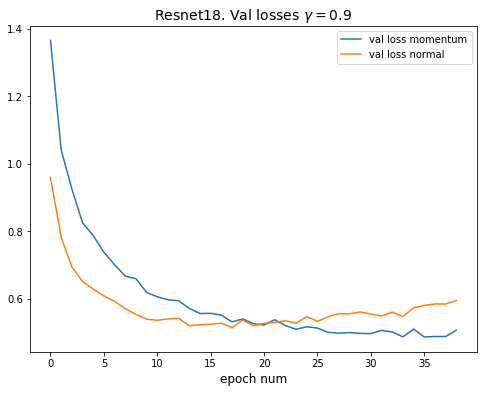

In [ ]:
plt.figure(figsize=(8, 6))
plt.title(r'Resnet18. Val losses $\gamma=0.9$', fontsize=14)
plt.plot(mom9test_losses, label='val loss momentum')
plt.plot(test_losses, label='val loss normal')
plt.xlabel('epoch num', fontsize=12)
plt.legend()
plt.savefig('3', dpi=150)
plt.show()

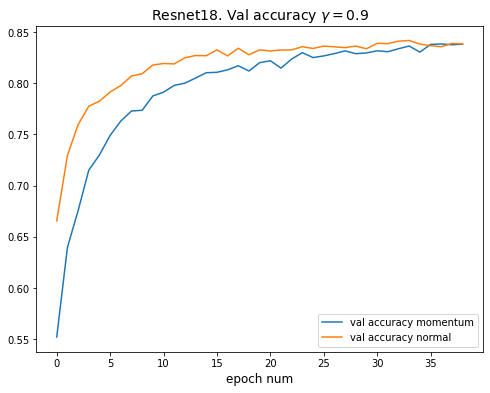

In [ ]:
plt.figure(figsize=(8, 6))
plt.title(r'Resnet18. Val accuracy $\gamma=0.9$', fontsize=14)
plt.plot(mom9test_acc, label='val accuracy momentum')
plt.plot(test_acc, label='val accuracy normal')
plt.xlabel('epoch num', fontsize=12)
plt.legend()
plt.savefig('4', dpi=150)
plt.show()